In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

DATA_DIR = "./data"

# Load datasets
merged_df = pd.read_csv(f"{DATA_DIR}/output/clean_data.csv")


In [23]:
merged_df.shape

(420212, 19)

In [24]:
# Convert Date column to datetime format
merged_df['Date'] = pd.to_datetime(merged_df['Date'])



# Creating Train-Test Splits¶


In [25]:
merged_df = merged_df.drop(columns=['Type'])


In [26]:
train_data = merged_df[:int(0.7*(len(merged_df)))] # taking train part
test_data = merged_df[int(0.7*(len(merged_df))):] # taking test part

target = "Weekly_Sales"
used_cols = [c for c in merged_df.columns.to_list() if c not in [target]] # all columns except weekly sales

X_train = train_data[used_cols]
X_test = test_data[used_cols]
y_train = train_data[target]
y_test = test_data[target]

In [27]:
X = merged_df[used_cols] # to keep train and test X values together


In [28]:
X_train = X_train.drop(['Date'], axis=1) # dropping date from train
X_test = X_test.drop(['Date'], axis=1) # dropping date from test

In [29]:
def wmae_test(test, pred): # WMAE for test 
    weights = X_test['IsHoliday'].apply(lambda is_holiday:5 if is_holiday else 1)
    error = np.sum(weights * np.abs(test - pred), axis=0) / np.sum(weights)
    return error

# Random Forest Regressor¶


In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer

# Define the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=35,
                           max_features='sqrt', min_samples_split=10)

# Define the RobustScaler
scaler = RobustScaler()

# Define the SimpleImputer to fill missing values
imputer = SimpleImputer(strategy='mean')  

# Create a pipeline to use the imputer, scaler, and regressor together
pipe = Pipeline(steps=[
    ('imputer', imputer),
    ('scaler', scaler),
    ('regressor', rf)
])

# Fit the pipeline
pipe.fit(X_train, y_train)

# Predictions on train set
y_pred_train_rf = pipe.predict(X_train)

# Predictions on test set
y_pred_test_rf = pipe.predict(X_test)


In [31]:
wmae_test(y_test, y_pred_test_rf)


12347.132596948839

# Evaluate the model


In [32]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae_rf = mean_absolute_error(y_test, y_pred_test_rf)
mse_rf = mean_squared_error(y_test, y_pred_test_rf)
rmse_rf = np.sqrt(mse_rf)


print(f"Mean Absolute Error: {mae_rf}")
print(f"Mean Squared Error: {mse_rf}")
print(f"Root Mean Squared Error: {rmse_rf}")

Mean Absolute Error: 12058.001095097934
Mean Squared Error: 217428479.9276922
Root Mean Squared Error: 14745.45624684744


# Feature Importance


In [33]:
# Extract the trained RandomForestRegressor model from the pipeline
rf_model = pipe.named_steps['regressor']

# Get feature importances
importances = rf_model.feature_importances_
feature_names = X_train.columns  # Ensure you have feature names from your training data
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

print(feature_importance)

         Feature  Importance
2           Dept    0.539347
0     Unnamed: 0    0.240140
8           Size    0.129289
1          Store    0.037896
9           week    0.015245
4     Fuel_Price    0.010887
10         month    0.007009
7      MarkDown3    0.005602
5      MarkDown1    0.005414
6      MarkDown2    0.003617
14  Thanksgiving    0.001813
11          year    0.001514
3      IsHoliday    0.000990
15     Christmas    0.000659
12    Super Bowl    0.000311
13     Labor Day    0.000267


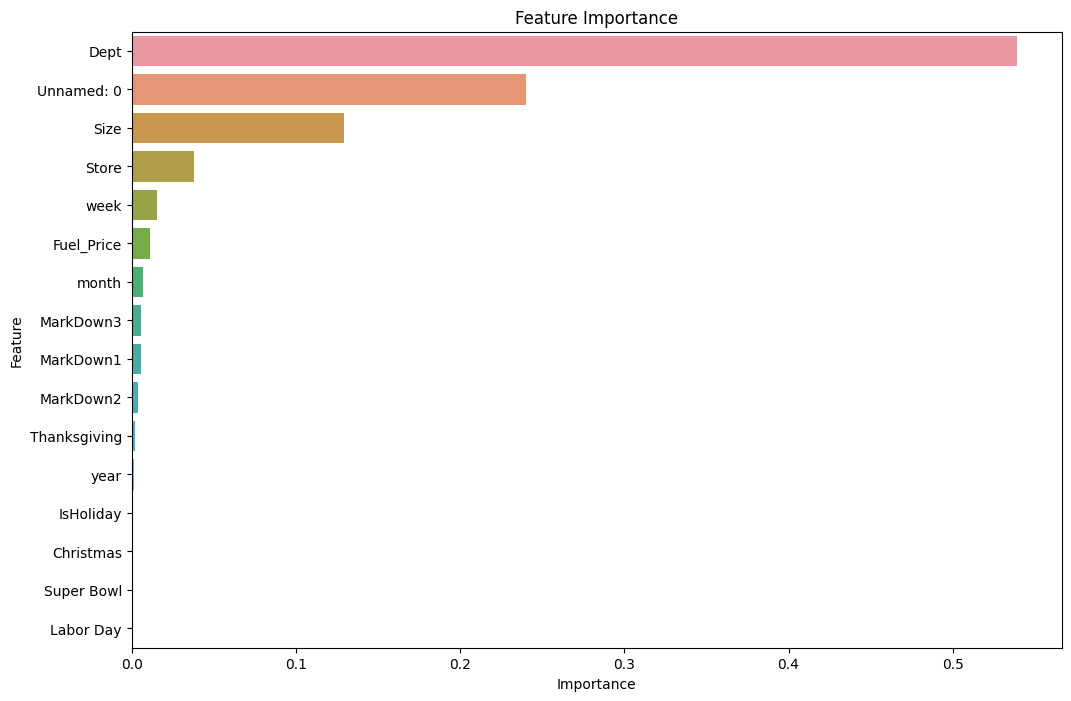

In [34]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance')
plt.show()

# Train XGBoost Model

In [35]:
import xgboost as xgb

# Define the model
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred_train_xgb = model.predict(X_train)
y_pred_test_xgb = model.predict(X_test)


# Evaluate the Model



In [36]:
# Calculate performance metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train_xgb))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test_xgb))
train_mae = mean_absolute_error(y_train, y_pred_train_xgb)
test_mae = mean_absolute_error(y_test, y_pred_test_xgb)

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')
print(f'Train MAE: {train_mae}')
print(f'Test MAE: {test_mae}')


Train RMSE: 8205.571452511489
Test RMSE: 12278.625972756801
Train MAE: 4799.484941174729
Test MAE: 8792.227040023652


Visualize Results:



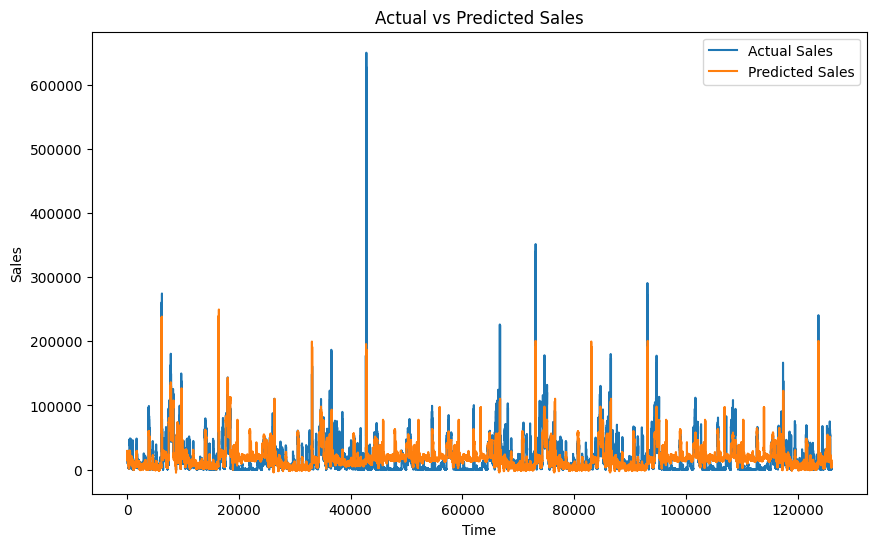

In [37]:
# Plot actual vs predicted sales
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Sales')
plt.plot(y_pred_test_xgb, label='Predicted Sales')
plt.legend()
plt.title('Actual vs Predicted Sales')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.show()


# Compare XGBoost and Random Forest


In [38]:
# Calculate performance metrics for Random Forest
train_rmse_rf = np.sqrt(mean_squared_error(y_train, y_pred_train_rf))
test_rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_test_rf))
train_mae_rf = mean_absolute_error(y_train, y_pred_train_rf)
test_mae_rf = mean_absolute_error(y_test, y_pred_test_rf)
train_r2_rf = r2_score(y_train, y_pred_train_rf)
test_r2_rf = r2_score(y_test, y_pred_test_rf)


print(f'Random Forest - Train RMSE: {train_rmse_rf}')
print(f'Random Forest - Test RMSE: {test_rmse_rf}')
print(f'Random Forest - Train MAE: {train_mae_rf}')
print(f'Random Forest - Test MAE: {test_mae_rf}')
print(f'Random Forest - Train R2: {train_r2_rf}')
print(f'Random Forest - Test R2: {test_r2_rf}')



Random Forest - Train RMSE: 5253.6508598985765
Random Forest - Test RMSE: 14745.45624684744
Random Forest - Train MAE: 2701.5840202567074
Random Forest - Test MAE: 12058.001095097934
Random Forest - Train R2: 0.951895315298948
Random Forest - Test R2: 0.41676044592714834


In [39]:
# Compare XGBoost and Random Forest
models = ['XGBoost', 'Random Forest']
train_rmse_values = [train_rmse, train_rmse_rf]
test_rmse_values = [test_rmse, test_rmse_rf]
train_mae_values = [train_mae, train_mae_rf]
test_mae_values = [test_mae, test_mae_rf]



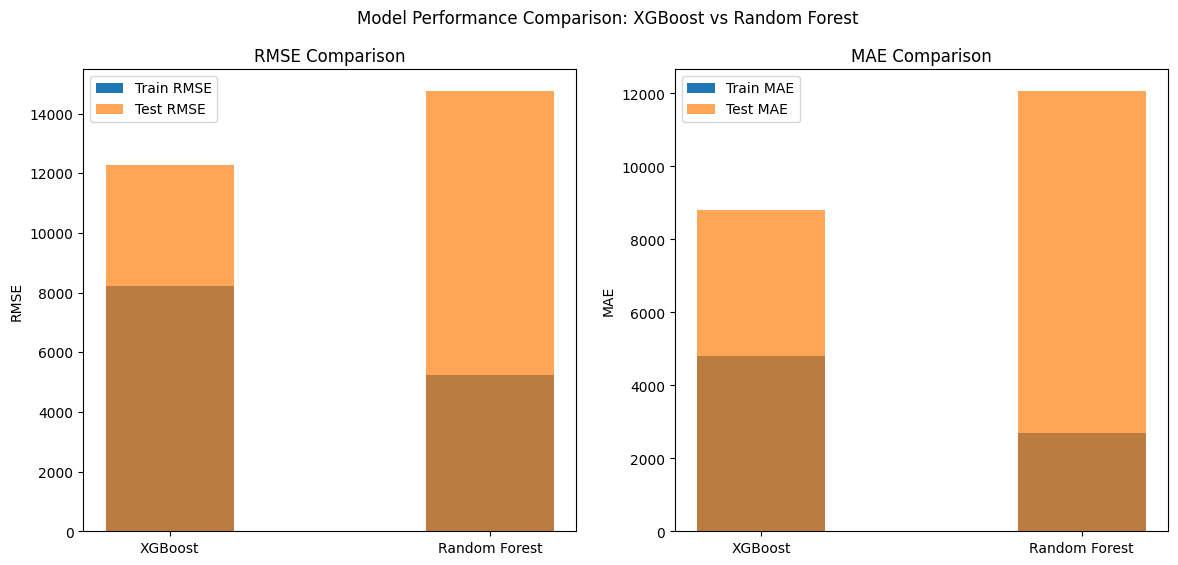

In [40]:
# Visualize the comparison
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# RMSE comparison
axs[0].bar(models, train_rmse_values, width=0.4, label='Train RMSE')
axs[0].bar(models, test_rmse_values, width=0.4, label='Test RMSE', alpha=0.7)
axs[0].set_title('RMSE Comparison')
axs[0].set_ylabel('RMSE')
axs[0].legend()

# MAE comparison
axs[1].bar(models, train_mae_values, width=0.4, label='Train MAE')
axs[1].bar(models, test_mae_values, width=0.4, label='Test MAE', alpha=0.7)
axs[1].set_title('MAE Comparison')
axs[1].set_ylabel('MAE')
axs[1].legend()

plt.suptitle('Model Performance Comparison: XGBoost vs Random Forest')
plt.show()

# Summary and Conclusion


In [41]:
print("Summary and Conclusion:")
print("1. Time-based factors such as year, month, and week show a clear impact on sales.")
print("2. Space-based factors like store size and type also influence the sales.")
print("3. Holidays significantly increase the sales as seen from the box plot.")
print("4. The Random Forest model shows a reasonable prediction accuracy with RMSE of", rmse_rf)

Summary and Conclusion:
1. Time-based factors such as year, month, and week show a clear impact on sales.
2. Space-based factors like store size and type also influence the sales.
3. Holidays significantly increase the sales as seen from the box plot.
4. The Random Forest model shows a reasonable prediction accuracy with RMSE of 14745.45624684744
